In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install PyPDF2

In [ ]:
pip install python-docx

In [ ]:
pip install langchain

In [ ]:
pip install openai

In [ ]:
pip install flask

In [ ]:
pip install tiktoken

In [ ]:
pip install faiss-cpu

In [ ]:
pip install textstat

In [38]:

import os
from PyPDF2 import PdfReader
import docx

from flask import Flask, request, render_template, jsonify


from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.callbacks import get_openai_callback


os.environ['OPENAI_API_KEY'] = 'key'
api_key="key"

def read_pdf(file_path):
    text = ""
    with open(file_path, "rb") as file:
        pdf_reader = PdfReader(file)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

def read_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([paragraph.text for paragraph in doc.paragraphs if paragraph.text])
    return text

def read_files(file_paths):
    full_text = ""
    for file_path in file_paths:
        if file_path.endswith('.pdf'):
            full_text += read_pdf(file_path) + "\n"
        elif file_path.endswith('.docx'):
            full_text += read_docx(file_path) + "\n"
    return full_text

def process_text(full_text, query):
    # split into chunks
    char_text_splitter = CharacterTextSplitter(separator="\n", chunk_size=1000, chunk_overlap=200, length_function=len)
    text_chunks = char_text_splitter.split_text(full_text)

    # create embeddings
    embeddings = OpenAIEmbeddings(openai_api_key=api_key)
    docsearch = FAISS.from_texts(text_chunks, embeddings)

    llm = OpenAI()
    chain = load_qa_chain(llm, chain_type="stuff")

    # process user query
    docs = docsearch.similarity_search(query)
    response = chain.run(input_documents=docs, question=query)
    return response

file_paths = ["D:/Text vectorization/document2.pdf", "D:/Text vectorization/document2.pdf", "D:/Text vectorization/document2.pdf", "D:/Text vectorization/document1.docx","D:/Text vectorization/greetings.docx"]
combined_text = read_files(file_paths)


In [39]:

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_basic_stats(text):
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    num_paragraphs = text.count('\n')
    return {
        'Total Words': num_words,
        'Total Sentences': num_sentences,
        'Total Paragraphs': num_paragraphs
    }

stats = compute_basic_stats(combined_text)
print(stats)


{'Total Words': 6204, 'Total Sentences': 405, 'Total Paragraphs': 430}


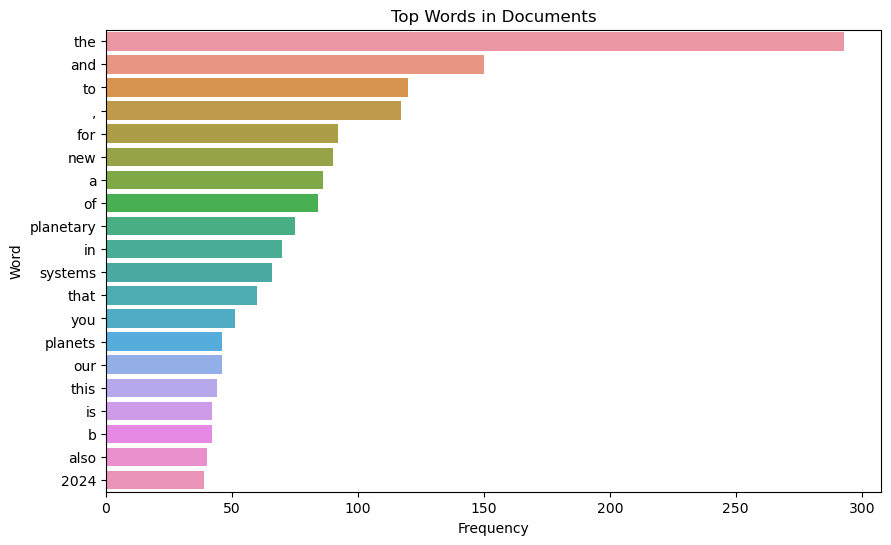

In [41]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


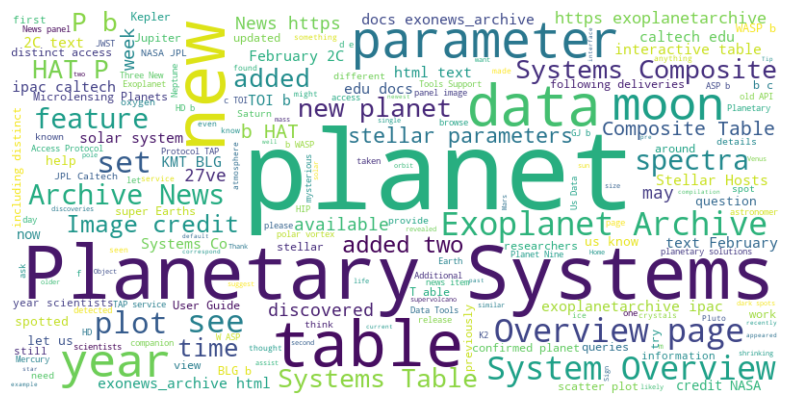

In [43]:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_lda(text, n_topics=5):
    # Ensure proper settings for a single document scenario
    vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words='english')
    dtm = vectorizer.fit_transform([text])  # Assuming a single document
    lda = LatentDirichletAllocation(n_components=n_topics)
    lda.fit(dtm)
    
    # Display topics
    for index, topic in enumerate(lda.components_):
        print(f'TOPIC {index}')
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

perform_lda(combined_text)



TOPIC 0
['inert', 'hypothetical', 'hypothesis', 'human', 'hot', 'horizons', 'hopkins', 'hole', 'invisible', 'zircon']
TOPIC 1
['stellar', 'archive', 'data', 'planet', 'planets', '2024', 'systems', 'table', 'planetary', 'new']
TOPIC 2
['inert', 'hypothetical', 'hypothesis', 'human', 'hot', 'horizons', 'hopkins', 'hole', 'invisible', 'zircon']
TOPIC 3
['inert', 'hypothetical', 'hypothesis', 'human', 'hot', 'horizons', 'hopkins', 'hole', 'invisible', 'zircon']
TOPIC 4
['inert', 'hypothetical', 'hypothesis', 'human', 'hot', 'horizons', 'hopkins', 'hole', 'invisible', 'zircon']


In [44]:

import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

# After downloading, you can proceed with sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    print("Sentiment Scores:", sentiment)

analyze_sentiment(combined_text)



Sentiment Scores: {'neg': 0.014, 'neu': 0.905, 'pos': 0.082, 'compound': 0.9999}


[nltk_data] Downloading package vader_lexicon to C:\Users\Dhananjeyan
[nltk_data]     M S\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:

import textstat

def readability_scores(text):
    scores = {
        'Flesch Reading Ease': textstat.flesch_reading_ease(text),
        'SMOG Index': textstat.smog_index(text),
        'Flesch-Kincaid Grade': textstat.flesch_kincaid_grade(text),
        'Coleman-Liau Index': textstat.coleman_liau_index(text),
        'Automated Readability Index': textstat.automated_readability_index(text),
        'Dale-Chall Readability Score': textstat.dale_chall_readability_score(text)
    }
    return scores

readability = readability_scores(combined_text)






In [47]:

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def named_entity_recognition_nltk(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Part-of-speech tagging
    tagged_words = pos_tag(words)
    # Named entity recognition
    tree = ne_chunk(tagged_words)
    
    # Extract and return named entities
    named_entities = []
    for subtree in tree:
        if type(subtree) == nltk.Tree:  # If subtree is a named entity
            entity_type = subtree.label()
            entity_name = " ".join(token for token, pos in subtree.leaves())
            named_entities.append((entity_name, entity_type))
    
    return named_entities

entities = named_entity_recognition_nltk(combined_text)



[nltk_data] Downloading package punkt to C:\Users\Dhananjeyan M
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dhananjeyan M S\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Dhananjeyan M S\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Dhananjeyan M
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


C:\Users\Dhananjeyan M S\AppData\Local\Temp\ipykernel_29492\3947733019.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(entity_types)
C:\Users\Dhananjeyan M S\AppData\Local\Temp\ipykernel_29492\3947733019.py:8: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  counts = pd.value_counts(entity_types)


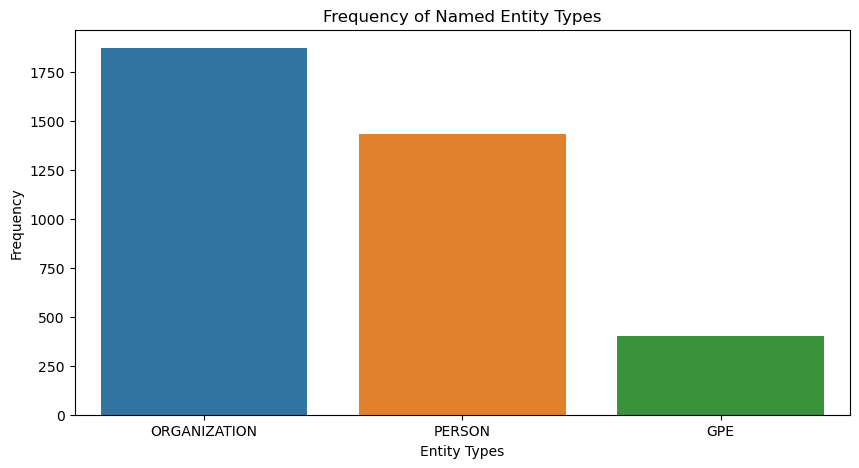

In [48]:
import seaborn as sns

# Assuming named_entities is a list of tuples (entity, type) from previous example
named_entities = entities * 10  # Example data

def plot_entity_distribution(named_entities):
    entity_types = [ne[1] for ne in named_entities]
    counts = pd.value_counts(entity_types)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title('Frequency of Named Entity Types')
    plt.ylabel('Frequency')
    plt.xlabel('Entity Types')
    plt.show()

plot_entity_distribution(named_entities)


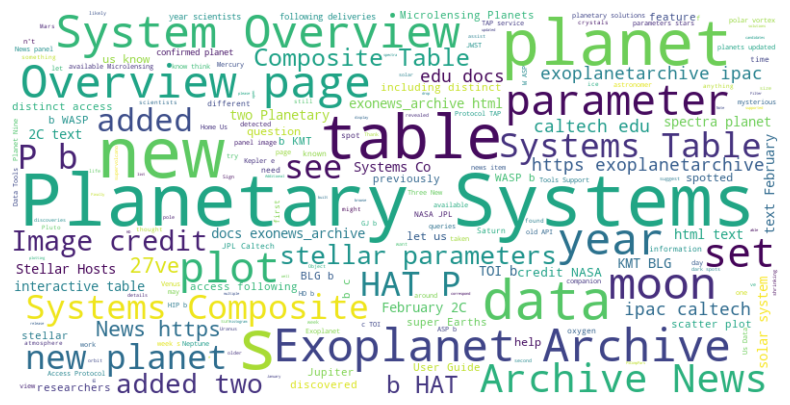

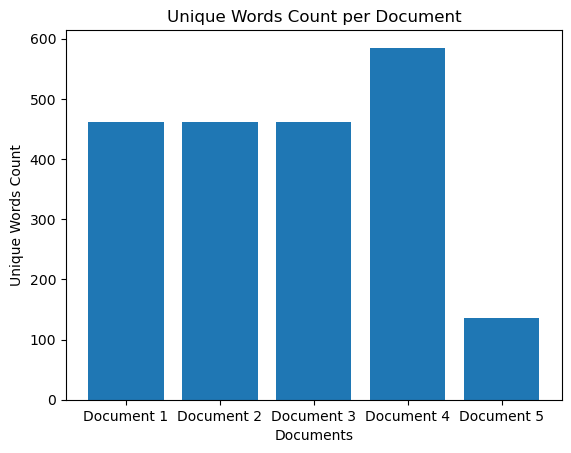

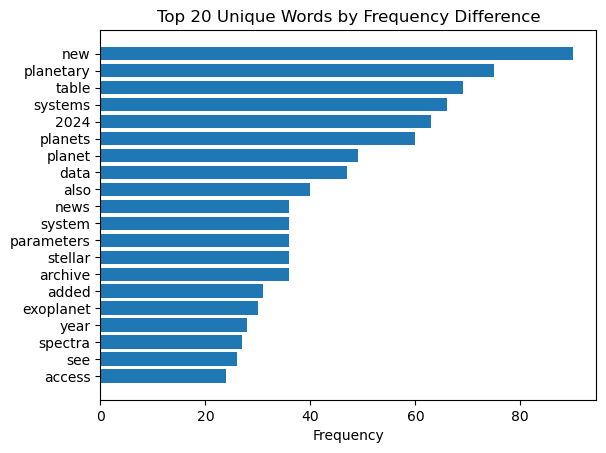

In [54]:
import os
import docx
from PyPDF2 import PdfReader
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import numpy as np

# Your Flask and langchain imports as they were

# Setting API keys and other configuration (be cautious with exposing API keys directly in the code)


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load English stopwords
stop_words = set(stopwords.words('english'))

def read_pdf(file_path):
    text = ""
    with open(file_path, "rb") as file:
        pdf_reader = PdfReader(file)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                # Tokenize and remove stopwords
                words = word_tokenize(page_text)
                filtered_words = [word for word in words if word.lower() not in stop_words]
                text += " ".join(filtered_words) + "\n"
    return text

def read_docx(file_path):
    doc = docx.Document(file_path)
    text = ""
    for paragraph in doc.paragraphs:
        if paragraph.text:
            # Tokenize and remove stopwords
            words = word_tokenize(paragraph.text)
            filtered_words = [word for word in words if word.lower() not in stop_words]
            text += " ".join(filtered_words) + "\n"
    return text


def read_files(file_paths):
    texts = []
    for file_path in file_paths:
        if file_path.endswith('.pdf'):
            texts.append(read_pdf(file_path))
        elif file_path.endswith('.docx'):
            texts.append(read_docx(file_path))
    return texts

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_unique_words(texts):
    unique_words_counts = [len(set(text.split())) for text in texts]
    document_labels = [f'Document {i+1}' for i in range(len(texts))]
    plt.bar(document_labels, unique_words_counts)
    plt.xlabel('Documents')
    plt.ylabel('Unique Words Count')
    plt.title('Unique Words Count per Document')
    plt.show()

def plot_word_frequency_difference(texts):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    freqs = np.array(X.sum(axis=0))[0]
    terms = vectorizer.get_feature_names_out()
    sorted_idx = np.argsort(freqs)
    plt.barh(np.array(terms)[sorted_idx][-20:], freqs[sorted_idx][-20:])
    plt.xlabel('Frequency')
    plt.title('Top 20 Unique Words by Frequency Difference')
    plt.show()

# File paths
file_paths = ["D:/Text vectorization/document2.pdf", "D:/Text vectorization/document2.pdf", "D:/Text vectorization/document2.pdf", "D:/Text vectorization/document1.docx","D:/Text vectorization/greetings.docx"]
texts = read_files(file_paths)

# Combine texts for overall analysis
combined_text = " ".join(texts)

# Visualization
plot_word_cloud(combined_text)  # Plot word cloud for all combined texts
plot_unique_words(texts)       # Plot unique word counts for each document
plot_word_frequency_difference(texts)  # Plot word frequency differences
